# Analysis of Resource Ratios

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List
from fractions import Fraction

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [5]:
greedy_name = 'Greedy Utility / Sqrt Sum, Product, Pow percent sum'
fixed_greedy_name = 'Greedy Utility / Sqrt Sum, Product, Fixed Task Speeds'

# algorithms = [('Greedy', greedy_name), ('Fixed Greedy', fixed_greedy_name)]
algorithms = [('Elastic Greedy Algorithm', greedy_name), ('Non-Elastic Optimal', 'Fixed Optimal')]

ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratio_labels = ['1:9', '1:4', '3:7', '2:3', '1:1', '3:2', '7:3', '4:1', '9:1']

In [8]:
folder = '../data/alibaba/resource_ratio'
results_data = []

for filename in os.listdir(folder):
    if 't25_s5' in filename:
        print(filename)
        with open(f'{folder}/{filename}') as file:
            results_data += json.load(file)

print(f'Repeats: {len(results_data)}')
print(f'Algorithms: {list(results_data[0]["ratio 0.1"].keys())}')

resource_ratio_realistic_r_t25_s5_dt03-09_17-29-33.json
resource_ratio_realistic_r_t25_s5_dt03-09_17-02-42.json
Repeats: 8
Algorithms: ['Fixed Optimal', 'Greedy Utility / Sqrt Sum, Sum, Percent Sum', 'Greedy Utility / Sqrt Sum, Sum, Pow percent sum', 'Greedy Utility / Sqrt Sum, Product, Percent Sum', 'Greedy Utility / Sqrt Sum, Product, Pow percent sum', 'Greedy Utility / Sqrt Sum, Random, Percent Sum', 'Greedy Utility / Sqrt Sum, Random, Pow percent sum', 'Greedy Utility * deadline / Sum, Sum, Percent Sum', 'Greedy Utility * deadline / Sum, Sum, Pow percent sum', 'Greedy Utility * deadline / Sum, Product, Percent Sum', 'Greedy Utility * deadline / Sum, Product, Pow percent sum', 'Greedy Utility * deadline / Sum, Random, Percent Sum', 'Greedy Utility * deadline / Sum, Random, Pow percent sum', 'Greedy Utility * deadline / Sqrt Sum, Sum, Percent Sum', 'Greedy Utility * deadline / Sqrt Sum, Sum, Pow percent sum', 'Greedy Utility * deadline / Sqrt Sum, Product, Percent Sum', 'Greedy Utili

In [59]:
#results_filename = "../data/old/resource_ratio/resource_ratio_paper_r_t40_s8_dt07-27_00-30-22.json"
results_filename = "../data/old/resource_ratio/resource_ratio_paper_r_t15_s3_dt10-04_00-09-21.json"

with open(results_filename) as file:
    results_data = json.load(file)

### Resource ratio social welfare, social welfare percent and percentage tasks allocated

<ipython-input-8-de229321887e>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ratio_labels)


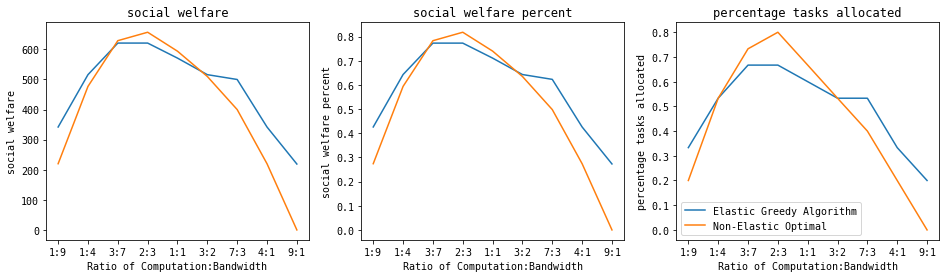

In [8]:
system_fig, (sw_ax, swp_ax, pta_ax) = plt.subplots(1, 3, figsize=(16, 4))
for ax, prop in [(sw_ax, 'social welfare'), (swp_ax, 'social welfare percent'), (pta_ax, 'percentage tasks allocated')]:
    for name, algo in algorithms:
        results = [results_data[0][f'ratio {ratio}'][algo][prop] for ratio in ratios]
        ax.plot(ratios, results, label=name)
    ax.set_title(prop)
    ax.set_xticklabels(ratio_labels)
    ax.set_xlabel('Ratio of Computation:Bandwidth')
    ax.set_ylabel(prop)
    ax.set_xticks(ratios)
    
# plt.legend(bbox_to_anchor=(0, -0.1))
plt.legend()

### Resource ratio server resource usage

In [62]:
def storage_resource_fn(model, task_name, loading_speed, compute_speed, sending_speed, server, task_prefix):
    return next(task for task in model['tasks'] if task_prefix + task['name'] == task_name)['storage']

def compute_resource_fn(model, task_name, loading_speed, compute_speed, sending_speed, server, task_prefix):
    return compute_speed

def bandwidth_resource_fn(model, task_name, loading_speed, compute_speed, sending_speed, server, task_prefix):
    return loading_speed + sending_speed

def ratio_resource_usage(algo, resource_fn, capacity, task_prefix=''):
    ratio_usage_percent = []

    for ratio in ratios:
        resource_usage_percent = []
    
        for results in results_data:
            model = results['model']
            algo_results = results[f'ratio {ratio}'][algo]

            server_usage = {server['name']: 0 for server in model['servers']}
            for task_name, resource_usage in algo_results['task resource usage'].items():
                server_usage[resource_usage[-1]] += resource_fn(model, task_name, *resource_usage, task_prefix)

            for server in model['servers']:
                resource_usage_percent.append(server_usage[server['name']] / server[capacity])
        
        ratio_usage_percent.append(resource_usage_percent)
    return np.array(ratio_usage_percent)

Algo: Elastic Greedy Algorithm - Mean: [0.47232561 0.72738482 0.8074663  0.81898173 0.78310848 0.69458522
 0.5728521  0.41079365 0.20909224], Error: [0.05213805 0.06643263 0.05769511 0.05410211 0.05732683 0.06627343
 0.06667158 0.04552223 0.01825475]
Algo: Non-Elastic Optimal - Mean: [0.26456859 0.57881903 0.83235037 0.87251549 0.77512298 0.62781886
 0.47298215 0.27933548 0.09293755], Error: [0.03642834 0.05545448 0.04883337 0.04185669 0.05326969 0.05868547
 0.04383514 0.03722474 0.04160253]
Algo: Elastic Greedy Algorithm - Mean: [0.68516136 1.37791012 1.98462932 2.50242845 3.1161094  3.23396401
 3.6927671  3.51636297 2.58006843], Error: [0.36510917 0.76678062 1.10342385 1.37047674 1.81093429 1.45746675
 2.35750168 2.02346498 1.40291397]
Algo: Non-Elastic Optimal - Mean: [0.64263454 1.44473709 2.23365178 2.3939247  2.04443967 1.57309436
 1.19252729 0.68809033 0.13404717], Error: [0.36429388 0.70227583 1.17027893 1.29240854 1.11111068 0.76348594
 0.64413638 0.36130838 0.06563349]
Algo: 

<ipython-input-68-f971517f62ee>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ratio_labels)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figs/png/resource_ratio_server_resource_usage.png
Save file location: figs/pdf/resource_ratio_server_resource_usage.pdf


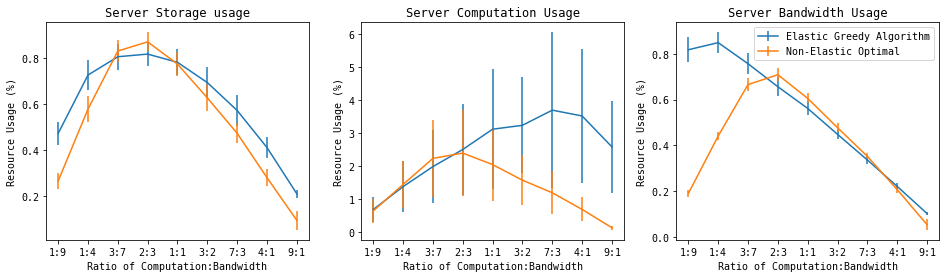

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for ax, title, resource_fn, capacity in zip(
        axs, ('Server Storage usage', 'Server Computation Usage', 'Server Bandwidth Usage'),
        (storage_resource_fn, compute_resource_fn, bandwidth_resource_fn), 
        ('storage capacity', 'computation capacity', 'bandwidth capacity')):
    for algo_name, algo_label, task_prefix in zip(
            (greedy_name, 'Fixed Optimal'), ('Elastic Greedy Algorithm', 'Non-Elastic Optimal'), ('', 'Fixed ')):
        resource_usage = ratio_resource_usage(algo_name, resource_fn, capacity, task_prefix)
        error = 1.96 * np.std(resource_usage, axis=1) / np.sqrt(len(results_data))
        print(f'Algo: {algo_label} - Mean: {np.mean(resource_usage, axis=1)}, Error: {error}')
        ax.errorbar(x=ratios, y=np.mean(resource_usage, axis=1), yerr=error, label=algo_label)
        
    ax.set_title(title)
    
    ax.set_xticklabels(ratio_labels)
    ax.set_xticks(ratios)
    ax.set_xlabel('Ratio of Computation:Bandwidth')
    
    ax.set_ylabel('Resource Usage (%)')

# plt.legend(bbox_to_anchor=(0, -0.1))
plt.legend()
save_plot('resource_ratio_server_resource_usage')

## Resource ratio social welfare percentage average

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Algo: Greedy Utility / Sqrt Sum, Product, Pow percent sum - Mean: [431.12 599.24 646.88 651.44 633.2  583.36 500.64 380.52 216.  ], Error: [23.43971728 28.56650721 29.53138081 29.82500875 29.24624756 30.55305034
 29.43434632 23.12550701 11.23666479]
Algo: Fixed Optimal - Mean: [255.32 496.2  646.44 669.44 610.8  526.76 419.6  277.16  82.52], Error: [16.3082252  21.34122309 27.14702994 28.17562931 27.03106484 24.1253705
 22.18927764 19.22948558 23.52995992]
Save file location: figs/eps/resource_ratio_social_welfare.eps
Save file location: figs/png/resource_ratio_social_welfare.png
Save file location: figs/pdf/resource_ratio_social_welfare.pdf


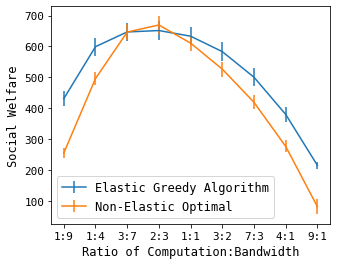

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
for name, algo in algorithms:
    social_welfares = [[result[f'ratio {ratio}'][algo]['social welfare'] for result in results_data] for ratio in ratios]
    error = 1.96 * np.std(social_welfares, axis=1) / np.sqrt(len(results_data))
    print(f'Algo: {algo} - Mean: {np.mean(social_welfares, axis=1)}, Error: {error}')
    ax.errorbar(x=ratios, y=np.mean(social_welfares, axis=1), yerr=error, label=name)

ax.set_ylabel('Social Welfare', fontsize=12)
plt.yticks(fontsize=11)
ax.set_xlabel('Ratio of Computation:Bandwidth', fontsize=12)
plt.xticks(ticks=ratios, labels=ratio_labels, fontsize=11)

plt.legend(fontsize=12)
save_plot('resource_ratio_social_welfare')

In [13]:
for ratio in ratios:
    difference = round(np.mean([r[f'ratio {ratio}'][greedy_name]['social welfare percent'] - 
                                r[f'ratio {ratio}']['Fixed Optimal']['social welfare percent']
                                for r in results_data]), 3)
    print(f'Ratio: {ratio}, difference: {difference}')

Ratio: 0.1, difference: 0.234
Ratio: 0.2, difference: 0.136
Ratio: 0.3, difference: 0.0
Ratio: 0.4, difference: -0.024
Ratio: 0.5, difference: 0.03
Ratio: 0.6, difference: 0.075
Ratio: 0.7, difference: 0.107
Ratio: 0.8, difference: 0.137
Ratio: 0.9, difference: 0.177


## Resource ratio social welfare difference

In [ ]:
diff_fig, diff_ax = plt.subplots(figsize=(7, 6))

differences = [
    [result[f'ratio {ratio}'][greedy_name]['social welfare'] - 
     result[f'ratio {ratio}'][fixed_greedy_name]['social welfare']
     for result in results_data]
    for ratio in ratios
]

diff_ax.boxplot(differences, widths=0.8)
diff_ax.set_ylabel('Difference in Social Welfare')
plt.xticks(ticks=np.arange(len(ratios)+1), labels=['', '1:10', '1:5', '3:7', '2:3', '1:1', '5:2', '7:3', '5:1', '10:1'])
diff_ax.set_xlabel('Ratio of Computation:Bandwidth')
save_plot('social_welfare_difference', 'resource_ratio')